CARGANDO EL DATASET

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


EXTRAYENDO INFORMACIÓN DEL DATASET

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

ELIMINANDO COLUMNAS QUE NO SE OCUPAN, O NO SE PUEDEN PROCESAR

In [3]:
to_drop = [
    'Date',
    'Location',
    'WindGustDir',
    'WindDir9am',
    'WindDir3pm',
    'RainToday',
    'RISK_MM'
]

df.drop(to_drop, inplace=True, axis=1)

RELLENANDO TODOS LOS CAMPOS VACIOS CON 0, Y ALTERANDO LA COLUMNA 'RainTomorrow' DE 'Yes'/'No' A 1/-1 YA QUE ESTA COLUMNA ES LA QUE SERÁ UTILIZADA COMO TARGET

In [4]:
cleaned = df.fillna(0)
cleaned = cleaned.replace({'RainTomorrow' : {'No':-1, 'Yes':1}})

MATRIZ DE CORRELACION

In [5]:
rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1,0.736267,0.104255,0.467261,0.0729613,0.177285,0.176005,0.175749,-0.234211,0.00599903,-0.45126,-0.461623,0.0776249,0.0204888,0.901813,0.708865
MaxTemp,0.736267,1,-0.074839,0.588915,0.469967,0.0676901,0.0146804,0.0507999,-0.505432,-0.50927,-0.332293,-0.427279,-0.289865,-0.279053,0.88702,0.984562
Rainfall,0.104255,-0.074839,1,-0.0645494,-0.227525,0.133497,0.0868158,0.057759,0.223725,0.255312,-0.168085,-0.126728,0.198195,0.171993,0.0114774,-0.0791776
Evaporation,0.467261,0.588915,-0.0645494,1,0.366607,0.203001,0.193936,0.128895,-0.50589,-0.392785,-0.269907,-0.29316,-0.185032,-0.184287,0.545497,0.574275
Sunshine,0.0729613,0.469967,-0.227525,0.366607,1,-0.0328309,0.00803964,0.0560117,-0.491603,-0.629122,0.0409589,-0.0204637,-0.67561,-0.704202,0.291139,0.49018
WindGustSpeed,0.177285,0.0676901,0.133497,0.203001,-0.0328309,1,0.604837,0.686419,-0.215461,-0.0266629,-0.457891,-0.412922,0.0712355,0.109088,0.150258,0.0329697
WindSpeed9am,0.176005,0.0146804,0.0868158,0.193936,0.00803964,0.604837,1,0.519971,-0.270807,-0.0316075,-0.227923,-0.174916,0.0242804,0.0535843,0.129298,0.00510815
WindSpeed3pm,0.175749,0.0507999,0.057759,0.128895,0.0560117,0.686419,0.519971,1,-0.145942,0.0159032,-0.295567,-0.254988,0.0527796,0.0252686,0.163601,0.0285673
Humidity9am,-0.234211,-0.505432,0.223725,-0.50589,-0.491603,-0.215461,-0.270807,-0.145942,1,0.667388,0.139519,0.186955,0.452182,0.358043,-0.472826,-0.499777
Humidity3pm,0.00599903,-0.50927,0.255312,-0.392785,-0.629122,-0.0266629,-0.0316075,0.0159032,0.667388,1,-0.0274495,0.0518397,0.517037,0.52327,-0.221467,-0.557989


DIVIDENDO EL DATASET, Y TRANSFORMANDOLO

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = cleaned.iloc[:,:-1].values, cleaned.iloc[:,-1].values

train, test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(train)
X_test_std = sc.transform(test)

APLICANDO PCA AL DATASET DE ENTRENAMIENTO Y PRUEBAS

In [7]:
from plot_regions import plot_decision_regions
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [8]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=5, random_state=0)

APLICANDO LA VALIDACION CRUZADA

In [11]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X_train_pca, y=y_train, cv=5)

In [12]:
print(all_accuracies.mean())

0.7450645501582357


CONFIGURANDO PARAMETROS DE GridSearch

In [13]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

#grid_params = {
#    'n_estimators': [1, 3, 5, 8, 10],
#    'criterion': ['gini', 'entropy'],
#    'bootstrap': [True, False]
#}

#gd_sr = GridSearchCV(estimator=classifier,
#                    param_grid=grid_params,
#                    scoring='accuracy',
#                    cv=5,
#                    n_jobs=-1)

parameters={'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC(kernel='rbf')
Cs = [1, 3, 5, 8, 10]
Gammas = [1e-3, 1e-4]

gd_sr = GridSearchCV(svr,
                dict(C=Cs,
                    gamma=Gammas),
                    cv=2,
                    pre_dispatch='1*n_jobs',
                    n_jobs=1)

ENTRENANDO ...

In [14]:
gd_sr.fit(X_train_pca, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': [1, 3, 5, 8, 10], 'gamma': [0.001, 0.0001]},
       pre_dispatch='1*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

MOSTRANDO RESULTADOS

In [15]:
best_parameters= gd_sr.best_params_
print(best_parameters)

{'C': 1, 'gamma': 0.001}


In [16]:
best_result = gd_sr.best_score_
print(best_result)

0.7764103079318833


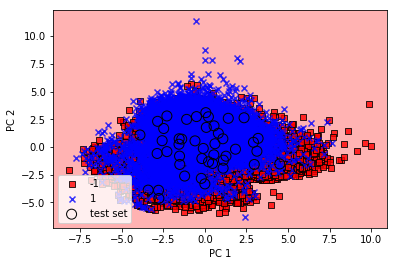

In [17]:
plot_decision_regions(X_test_pca, y_test, classifier=gd_sr, test_idx=range(105, 150))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

GRAFICA DE LAS CARACTERISTICAS DEL PCA

([array([1.6100e+02, 1.2540e+03, 1.2006e+04, 3.1654e+04, 3.2100e+04,
         1.7164e+04, 4.5420e+03, 6.1900e+02, 3.1000e+01, 4.0000e+00]),
  array([1.0000e+00, 1.2950e+03, 6.8410e+03, 3.2278e+04, 4.2708e+04,
         1.5223e+04, 1.1400e+03, 4.1000e+01, 7.0000e+00, 1.0000e+00])],
 array([-8.07038869, -6.13958693, -4.20878517, -2.27798341, -0.34718164,
         1.58362012,  3.51442188,  5.44522364,  7.3760254 ,  9.30682717,
        11.23762893]),
 <a list of 2 Lists of Patches objects>)

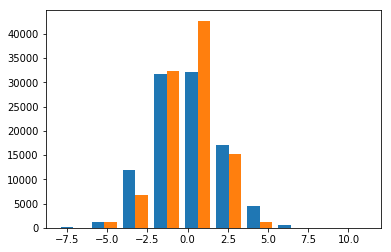

In [9]:
import matplotlib.pyplot as plt

plt.hist(X_train_pca)

([array([6.3000e+01, 5.1800e+02, 5.0150e+03, 1.3449e+04, 1.3991e+04,
         7.4870e+03, 1.8690e+03, 2.5000e+02, 1.3000e+01, 3.0000e+00]),
  array([1.0000e+00, 5.4200e+02, 2.8110e+03, 1.3686e+04, 1.8412e+04,
         6.6590e+03, 5.2500e+02, 1.6000e+01, 5.0000e+00, 1.0000e+00])],
 array([-8.15881424, -6.21028844, -4.26176264, -2.31323684, -0.36471104,
         1.58381476,  3.53234055,  5.48086635,  7.42939215,  9.37791795,
        11.32644375]),
 <a list of 2 Lists of Patches objects>)

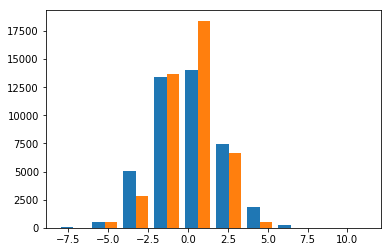

In [61]:
import matplotlib.pyplot as plt

plt.hist(X_test_pca)

In [20]:
gd_sr.cv_results_

/home/miguelruiz/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/miguelruiz/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/miguelruiz/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/miguelruiz/.local/lib/py

{'mean_fit_time': array([164.42259336, 132.06673169, 184.12807906, 141.28181446,
        184.86006582, 142.91592693, 195.43561864, 142.10196733,
        189.28766787, 141.3491292 ]),
 'std_fit_time': array([ 3.81432843,  1.98801184, 13.4192251 ,  0.97840321,  7.42427051,
         0.45703888,  7.37632418,  1.5696137 ,  5.13843191,  1.81719565]),
 'mean_score_time': array([80.44895387, 79.64271045, 79.80639732, 81.12173831, 80.00587225,
        81.44816625, 79.94979179, 79.84409595, 79.52924597, 79.23283827]),
 'std_score_time': array([0.00553489, 0.00757718, 0.27474368, 0.80320704, 0.08756518,
        0.64051878, 0.32670724, 0.43186307, 0.29694831, 0.31628001]),
 'param_C': masked_array(data=[1, 1, 3, 3, 5, 5, 8, 8, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0001, 0.001,
                

UTILIZANDO KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

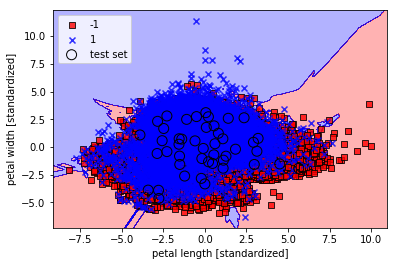

In [13]:
plot_decision_regions(X_test_pca, y_test, classifier=knn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

VALIDACION CRUZADA

In [17]:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=knn, X=X_train_pca, y=y_train, cv=5)

In [18]:
print(all_accuracies.mean())

0.768061485909479


BUSCANDO UN PARAMETRO OPTIMO ENTRE 1 Y 10

In [20]:
k_range = range(1, 11)

k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.7089566825038096, 0.7702214614030529, 0.7509820558877074, 0.7777465369131644, 0.767890711822762, 0.7820364897255396, 0.776329953312213, 0.7851911538985089, 0.7809514139804478, 0.7871200983783921]


Text(0, 0.5, 'Cross-Validated Accuracy')

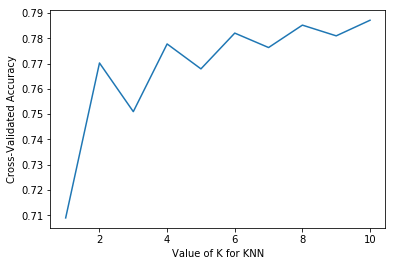

In [21]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

APLICANDO GridSearch

In [28]:
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 11))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [29]:
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


In [34]:
grid2 = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True)

RESULTADOS DE GridSearch

In [35]:
grid2.fit(X_train_pca, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [36]:
grid2.cv_results_

{'mean_fit_time': array([0.16605563, 0.1665005 , 0.16979172, 0.16679521, 0.1682034 ,
        0.16743674, 0.16743557, 0.16470077, 0.16759989, 0.16738369]),
 'std_fit_time': array([0.0121661 , 0.0140369 , 0.02059988, 0.01428893, 0.01410684,
        0.01590273, 0.01382484, 0.01257992, 0.0134159 , 0.01335368]),
 'mean_score_time': array([1.20136857, 1.24875243, 1.25297956, 1.26639707, 1.28656232,
        1.29123085, 1.30225024, 1.31369734, 1.3123709 , 1.33291686]),
 'std_score_time': array([0.01904087, 0.0158155 , 0.01033443, 0.00750031, 0.01548022,
        0.01049373, 0.01367845, 0.01689709, 0.01148256, 0.00890935]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},


In [47]:
print('Parameters')
print(grid2.cv_results_['params'][0])

print('')
print('Train Score')
print(grid2.cv_results_['split0_train_score'])

print('')
print('Mean Train Score')
print(grid2.cv_results_['mean_train_score'][0])

Parameters
{'n_neighbors': 1}

Train Score
[0.99994418 0.85380829 0.85367433 0.827709   0.82721783 0.81837666
 0.81791898 0.81324165 0.81319699 0.80932341]

Mean Train Score
0.9999006490361009


In [54]:
print('Best Params')
print(grid2.best_params_)

print('\nBest Score')
print(grid2.best_score_)

Best Params
{'n_neighbors': 10}

Best Score
0.7871201085045462


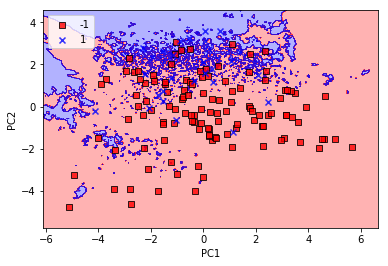

In [59]:
plot_decision_regions(X_test_pca[:150], y_test[:150], classifier=grid2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')
plt.show()